[![Colab Badge](http://img.shields.io/badge/Colaboratory-black?style=for-the-badge&logo=google-colab)](https://colab.research.google.com/github/TINYML-KOR/assignment/blob/main/Lab1_castleflag.ipynb)

# **MIT 6.5940 EfficientML.ai Fall 2023: Lab 1 Pruning**


This colab notebook provides code and a framework for ***Lab 1 Pruning***. You can work out your solutions here.



Please fill out this [feedback form](https://forms.gle/fapEmEUYr3WnXjBU8) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!

## Goals

- **pruning**의 기본 개념을 이해합니다.
- **fine-grained pruning**을 구현하고 적용합니다.
- **channel pruning**을 구현하고 적용합니다.
- pruning으로부터의 성능 개선(예: 속도 향상)에 대한 기본적인 이해를 얻습니다.
- 이러한 pruning 접근 방식 간의 차이점과 tradeoffs를 이해합니다.

## Contents

There are two main sections in this lab: ***Fine-grained Pruning*** and ***Channel Pruning***.

There are ***9*** questions in total:
- For *Fine-grained Pruning*, there are ***5*** questions (Question 1-5).
- For *Channel Pruning*, there are ***3*** questions (Question 6-8).
- Question 9 compares fine-grained pruning and channel pruning.


이 실습에는 ***Fine-grained Pruning***과 ***Channel Pruning***의 두 가지 주요 섹션이 있습니다.

총 ***9***개의 질문이 있습니다:
- *Fine-grained Pruning*에 대해서는 ***5***개의 질문이 있습니다 (Question 1-5).
- *Channel Pruning*에 대해서는 ***3***개의 질문이 있습니다 (Question 6-8).
- Question 9는 **fine-grained pruning**과 **channel pruning**을 비교합니다.

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [35]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [36]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [37]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [38]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [39]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [40]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [41]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [42]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [43]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [44]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [45]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### 먼저 Dense Model의 정확도와 모델 크기를 확인해봅시다

Neural networks는 많은 응용 프로그램에서 사용되고 있습니다. 여기서는 CIFAR10 데이터셋에서 이미지를 분류하기 위해 사전 훈련된 VGG 모델을 로드했습니다.

먼저 이 모델의 정확도와 모델 크기를 확인해봅시다.


In [48]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


큰 neural networks는 매우 강력하지만, 그 크기는 상당한 저장 공간, 메모리 대역폭, 그리고 계산 자원을 소비합니다.
위의 결과에서 볼 수 있듯이, $32\times32$ 이미지를 10개 클래스로 분류하는 것과 같이 간단한 작업을 위한 모델조차도 35 MiB 용량을 가집니다.
임베디드 모바일 응용 프로그램의 경우, 이러한 자원 요구 사항은 피해야 합니다.


따라서, **neural network pruning**은 DNN을 포함한 모바일 응용 프로그램의 저장 및 전송을 용이하게 하기 위해 쓰입니다.

pruning의 목표는 **정확도를 유지하면서 모델 크기를 줄이는 것**입니다.


# weight 값의 분포를 살펴봅시다.


pruning으로 넘어가기 전에, dense 모델에서 가중치 값의 분포를 살펴봅시다.

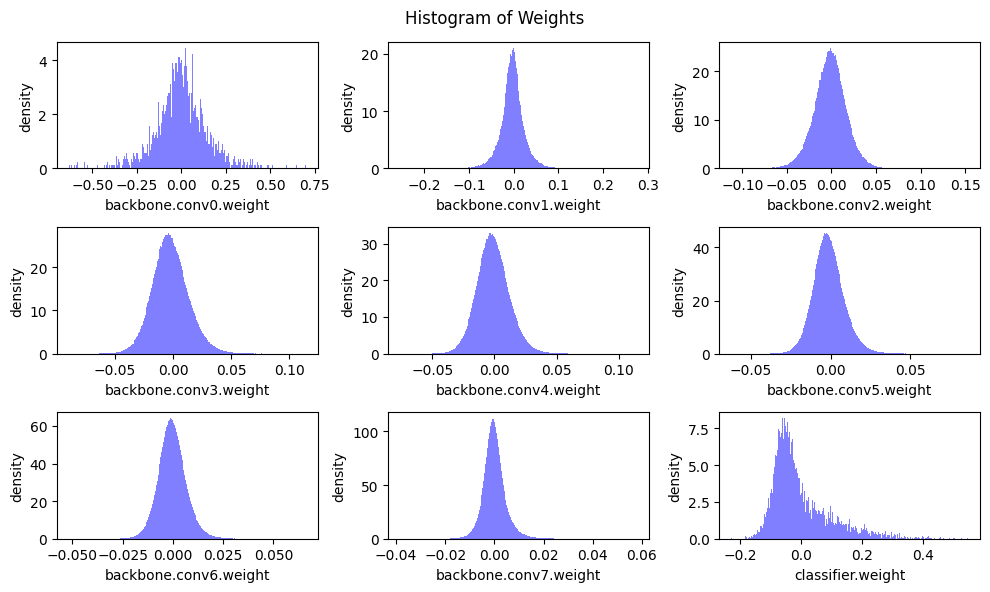

In [49]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## Question 1 (10 pts)

위 weight 히스토그램들을 보고 다음 질문에 답해 주세요.


### Question 1.1 (5 pts)

각기 다른 계층에서 weight 분포들의 공통적인 특성은 무엇인가요?


**Your Answer:**

mean이 0인 normal 분포를 따르고 있다 (backbone의 경우, classifier 제외)

### Question 1.2  (5 pts)

이러한 특성들이 pruning에 어떻게 도움이 되나요?


**Your Answer:**


0이 많으므로, 계산하지 않거나 없앨 수 있다.

# Fine-grained Pruning

이 섹션에서는 **fine-grained pruning**을 구현하고 수행할 것입니다.

Fine-grained pruning은 가장 중요도가 낮은 synapses를 제거합니다. Fine-grained pruning 후에는 가중치 텐서 $W$가 sparse해지며, 이는 **sparsity**로 설명할 수 있습니다:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

여기서 $\#W$는 $W$의 element 수입니다.

실제로, 목표 sparsity $s$가 주어지면, 가중치 텐서 $W$는 제거된 가중치를 무시하기 위해 이진 마스크 $M$과 곱해집니다:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

여기서 $Importance$는 $W$와 동일한 형태의 중요도 텐서이며, $\texttt{kthvalue}(X, k)$는 텐서 $X$의 $k$번째로 작은 값을 찾으며, $v_{\mathrm{thr}}$는 임계값입니다.


## Magnitude-based Pruning

Fine-grained pruning에 있어서 널리 사용되는 importance(중요도)는 weight 값의 크기, 즉,

$Importance=|W|$

입니다. **Magnitude-based Pruning**으로 알려져 있습니다 ([Learning both Weights and Connections for Efficient Neural Networks](https://arxiv.org/pdf/1506.02626.pdf) 참조).


![](https://github.com/TINYML-KOR/assignment/blob/main/images/lab1/pruning.png?raw=1)

### Question 2 (15 pts)

다음 magnitude-based fine-grained pruning 함수를 완성해 주세요.

**Hint**:
*   1단계에서는 pruning 후에 0의 개수(`num_zeros`)를 계산합니다. `num_zeros`는 정수여야 합니다. 부동 소수점 숫자를 정수로 변환하기 위해 `round()` 또는 `int()`를 사용할 수 있습니다. 여기서는 `round()`를 사용합니다.
*   2단계에서는 가중치 텐서의 `importance`를 계산합니다. Pytorch는 [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) API를 제공합니다.
*   3단계에서는 `threshold`를 계산하여 `threshold`보다 중요도가 낮은 모든 synapses가 제거되도록 합니다. Pytorch는 [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) API를 제공합니다.
*   4단계에서는 `threshold`를 기반으로 pruning `mask`를 계산합니다. `mask`에서 **1**은 synapse가 유지됨을 나타내고, **0**은 synapse가 제거됨을 나타냅니다. `mask = importance > threshold`. Pytorch는 [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API를 제공합니다.


In [50]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(torch.flatten(importance), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold

    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

위에서 정의한 fine-grained pruning 기능을 확인하기 위해, 더미 텐서에 위 함수를 적용해 봅시다.

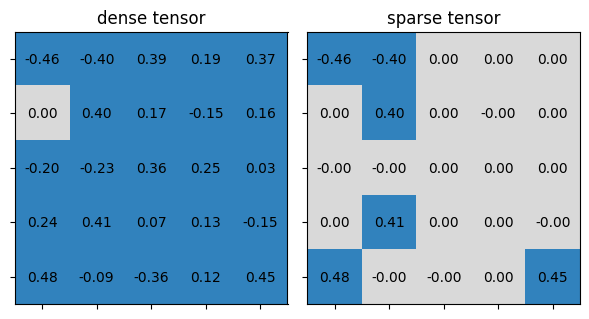

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [51]:
test_fine_grained_prune()

### Question 3 (5 pts)

마지막 셀은 pruning 전후의 텐서를 그립니다. 0이 아닌 값은 파란색으로, 0은 회색으로 표시됩니다. 다음 코드 셀에서 `target_sparsity`의 값을 수정하여 pruning 후 sparse 텐서에 0이 아닌 값이 10개만 남도록 해 주세요.

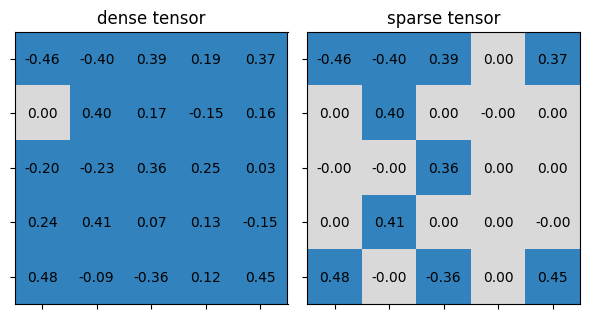

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [52]:
##################### YOUR CODE STARTS HERE #####################
# sparsity:=#Zeros/#𝑊=1−#Nonzeros/#𝑊
# 1 - 10/25
target_sparsity = 0.6 # please modify the value of target_sparsit
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

이제 fine-grained pruning 함수를 전체 모델을 pruning하는 클래스로 래핑합니다. `FineGrainedPruner` 클래스에서는 모델 가중치가 변경될 때마다 마스크를 적용하여 모델이 항상 sparse 상태를 유지할 수 있도록 pruning 마스크 기록을 가지고 있어야 합니다.


In [53]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


각 레이어는 모델 성능에 대해 각각 다르게 기여합니다. 각 레이어에 적절한 sparsity를 결정하는 것은 어려운 일입니다. 널리 사용되는 접근 방식은 **sensitivity scan**입니다.

sensitivity scan 동안, 각 시간마다 **하나의 레이어만을 prune**하여 accuracy 저하를 관찰합니다. 다양한 sparsities를 스캔함으로써, 해당 레이어의 sensitivity curve (즉, 정확도 대비 sparsity)를 그릴 수 있습니다.

다음은 **sensitivity curves**의 예시 그림입니다. x축은 sparsity 또는 #parameters가 감소한 비율 (*즉*, sparsity)입니다. y축은 검증 정확도입니다. ([Learning both Weights and Connections for Efficient Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)의 Figure 6)



![](https://github.com/TINYML-KOR/assignment/blob/main/images/lab1/sens_cur.png?raw=1)

다음 코드 셀은 스캔된 sparsities와 각 가중치가 prune될 때의 정확도 리스트를 반환하는 sensitivity scan 함수를 정의합니다.

In [54]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

다음 셀들을 실행하여 sensitivity curves를 그려주세요. 완료하는 데 약 2분 정도 걸릴 것입니다.


In [55]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

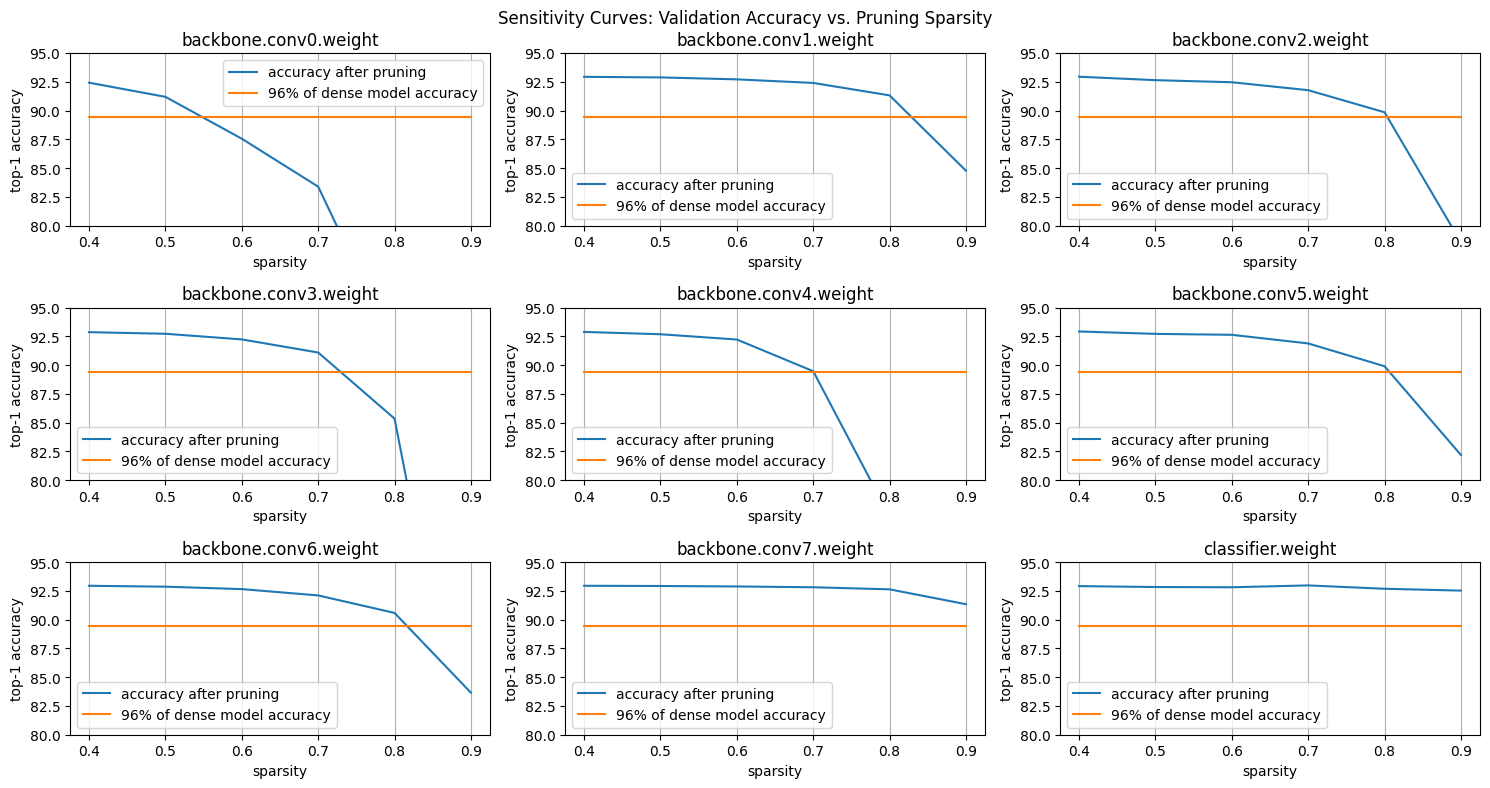

In [56]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

### Question 4 (15 pts)

위 sensitivity curves의 정보를 사용하여 다음 질문에 답해 주세요.


#### Question 4.1 (5 pts)

pruning sparsity와 모델 정확도 사이의 관계는 무엇인가요? (*즉*, sparsity가 높아질 때 정확도가 증가하나요, 아니면 감소하나요?)

**Your Answer:**

pruning sparsity가 높아질 수록, model accuracy는 감소하는 경향을 보인다

#### Question 4.2 (5 pts)

모든 레이어가 같은 sensitivity를 가지고 있나요?

**Your Answer:**


어떤 레이어는 sensitive하지 않고(classifier), 어떤 레이어는 sensitive하다(conv0)
대체로, 앞쪽 레이어(0~1..)이 민감해보인다

#### Question 4.3 (5 pts)

어떤 레이어가 pruning sparsity에 가장 민감한가요?


**Your Answer:**


conv0 layer

## \#Parameters of each layer

정확도뿐만 아니라 각 레이어의 매개변수(parameter) 수도 sparsity 선택에 영향을 미칩니다. **매개변수가 더 많은 레이어는 더 큰 sparsities를 요구합니다.**

다음 코드 셀을 실행하여 전체 모델에서 #parameters의 분포를 그려주세요.

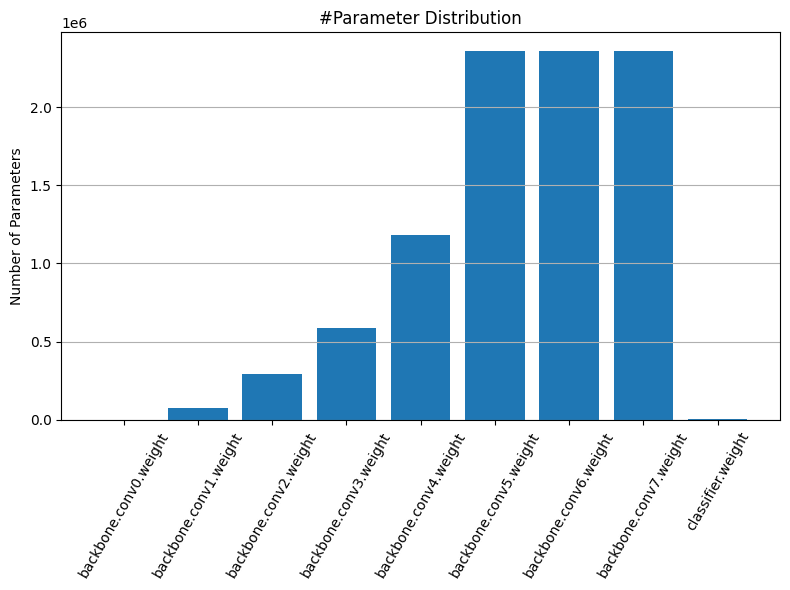

In [57]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## `Sensitivity Curves`와 `#Parameters 분포`를 기반으로 Sparsity 선택하기



### Question 5 (10 pts)

sensitivity curves와 모델의 `#parameters` 분포를 기반으로 각 레이어의 sparsity를 선택해 주세요.

pruned 모델의 전체 압축 비율은 대체로 #parameters가 큰 레이어에 주로 의존하며, 다른 레이어는 pruning에 대한 sensitivity가 다릅니다(Question 4 참조).

pruning 후에 sparse 모델이 dense 모델의 크기의 25%이며, finetuning 후에 검증 정확도가 92.5% 이상인지 확인하세요.

**Hint**:

*   `#parameters`가 더 많은 레이어는 더 큰 sparsity를 가져야 합니다. (*Figure `#Parameter` Distribution* 참조)
*   pruning sparsity에 민감한 레이어(즉, sparsity가 높아질수록 정확도가 빠르게 떨어지는 레이어)는 더 작은 sparsity를 가져야 합니다. (*Figure Sensitivity Curves* 참조)


In [58]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0,
    'backbone.conv1.weight': 0.5,
    'backbone.conv2.weight': 0.5,
    'backbone.conv3.weight': 0.5,
    'backbone.conv4.weight': 0.5,
    'backbone.conv5.weight': 0.8,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0
##################### YOUR CODE ENDS HERE #######################
}

정의된 `sparsity_dict`에 따라 모델을 prune하고 sparse 모델의 정보를 출력하기 위해 다음 셀을 실행해 주세요.


After pruning with sparsity dictionary
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.50
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.50
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.00
The sparsity of each layer becomes
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.50
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.50
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.00
Sparse model has size=8.63 MiB = 24.50% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=87.00% before fintuning


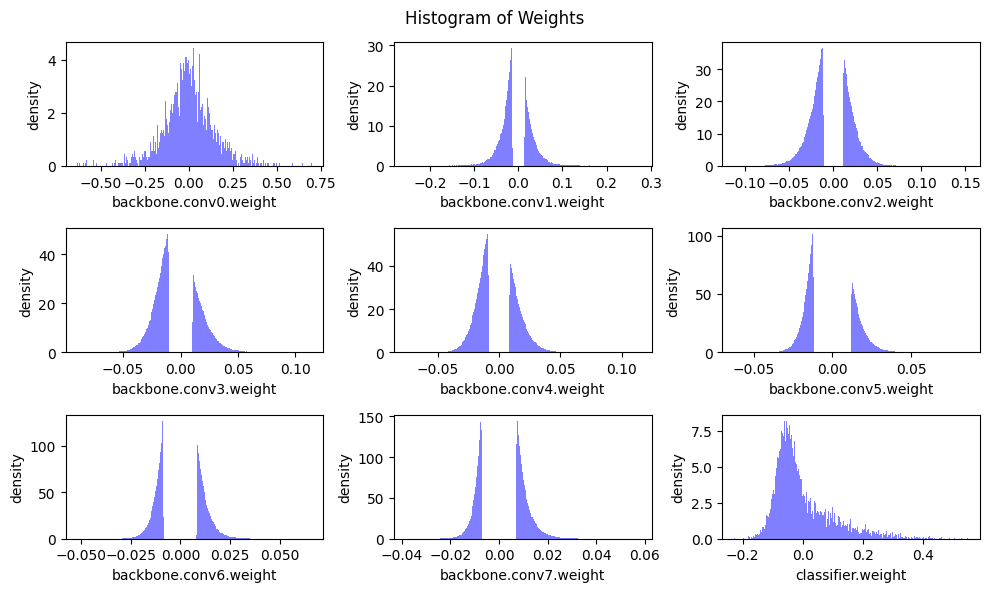

In [59]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

이전 셀의 출력에서 볼 수 있듯이, **fine-grained pruning이 모델 가중치의 대부분을 줄이지만 모델의 정확도도 떨어졌습니다.** 따라서, sparse 모델의 정확도를 회복하기 위해 **finetune해야 합니다.**

sparse 모델을 finetune하기 위해 다음 셀을 실행해 주세요. 완료하는 데 약 3분 정도 걸릴 것입니다.


In [60]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.66% / Best Accuracy: 92.66%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.77% / Best Accuracy: 92.77%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.80% / Best Accuracy: 92.80%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.68% / Best Accuracy: 92.80%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.77% / Best Accuracy: 92.80%


best finetuned sparse 모델의 정보를 보기 위해 다음 셀을 실행해 주세요.

In [61]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=8.63 MiB = 24.50% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.80% after fintuning


# Channel Pruning

이 섹션에서는 **channel pruning**을 구현할 것입니다. Channel pruning은 전체 채널을 제거하여 기존 하드웨어(예: GPU)에서 추론 속도를 향상시킬 수 있습니다. 마찬가지로, **더 작은 크기(Frobenius norm으로 측정)의 가중치를 가진 채널을 제거**합니다.


In [62]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


## Remove Channel Weights


Fine-grained pruning과 달리, channel pruning에서는 텐서에서 가중치를 완전히 제거할 수 있습니다. 즉, 출력 채널의 수가 줄어듭니다:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

Channel pruning 후에도 가중치 텐서 $W$는 여전히 dense합니다. 따라서, *sparsity*를 ***prune ratio***라고 합니다.

Fine-grained pruning처럼, 다른 레이어에 대해 다른 pruning 비율을 사용할 수 있습니다. 하지만 지금은 모든 레이어에 대해 **균일한 pruning 비율을 사용**합니다. 우리는 대략 30%의 균일한 pruning 비율로 2배의 계산 감소를 목표로 합니다(왜 그런지 생각해 보세요).

이 섹션의 끝에서 레이어별로 다른 pruning 비율을 시도해 볼 수 있습니다. `channel_prune` 함수에 비율 리스트를 전달할 수 있습니다.



### Question 6 (10 pts)

Channel pruning을 위한 다음 함수를 완성해 주세요.

여기서 우리는 첫 번째 $\#\mathrm{out\_channels}_{\mathrm{new}}$ 채널을 제외한 모든 출력 채널을 단순히 prune합니다.

In [63]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round((1-prune_ratio)*channels))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


구현이 올바른지 확인하기 위해 다음 셀을 실행하여 확인하세요.

In [64]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


이제 30% pruning 비율을 가진 균일 channel pruning 후 모델의 성능을 평가해 봅시다.

직접적으로 30%의 채널을 제거하는 것은 낮은 정확도로 이어집니다.


In [65]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%


## Ranking Channels by Importance

보시다시피, 모든 레이어에서 첫 30%의 채널을 제거하면 정확도가 크게 감소합니다. 이 문제를 해결하는 한 가지 가능한 방법은 **덜 중요한** 채널 가중치를 찾아서 제거하는 것입니다. 중요도를 평가하는 인기 있는 기준은 각 입력 채널에 해당하는 가중치의 Frobenius norm을 사용하는 것입니다:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

우리는 채널 가중치를 더 중요한 것에서 덜 중요한 것으로 정렬한 다음, 각 레이어에 대해 처음 $k$개의 채널을 유지할 수 있습니다.


### Question 7 (15 pts)


Frobenius norm에 기반하여 가중치 텐서를 정렬하는 다음 함수를 완성해 주세요.

**Hint**:


* 텐서의 Frobenius norm을 계산하기 위해, Pytorch는 [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) API를 제공합니다.


In [66]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight, p=2)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

이제 다음 셀을 실행하여 결과가 올바른지 확인하세요.


In [67]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


마지막으로 프루닝된 모델의 정확도를 정렬할 때와 그렇지 않을 때를 비교합니다.

In [68]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%


보시다시피 channel sorting은 pruned model의 정확도를 약간 향상시킬 수 있지만 여전히 channel pruning에 매우 일반적인 큰 저하가 있는 걸 알 수 있습니다. 이러한 정확도 저하를 회복하기 위해 fine-tuning을 수행할 수 있습니다.

In [69]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.66% / Best Accuracy: 91.66%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 92.10% / Best Accuracy: 92.10%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.01% / Best Accuracy: 92.10%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.18% / Best Accuracy: 92.18%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.16% / Best Accuracy: 92.18%


## Measure acceleration from pruning

fine-tuning이 끝나면 모델은 정확도를 거의 회복합니다. channel pruning는 fine-grained pruning에 비해 일반적으로 정확도를 회복하기가 더 어렵다는 것을 이미 알고 계실 수도 있습니다. 그러나 specialized model format이 없으면 직접적으로 모델 크기가 작아지고 계산이 작아집니다. GPU에서도 더 빠르게 실행될 수 있습니다.

이제 pruned model의 모델 크기, 계산 및 지연 시간을 비교해봅시다.

In [70]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    24.2            13.0            1.9            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


### Question 8 (10 pts)

이전 코드셀의 정보를 이용하여 다음 질문에 답변해 주시기 바랍니다.


#### Question 8.1 (5 pts)

30%의 채널을 제거하면 대략 50%의 계산 절감 효과가 발생하는 이유를 설명하세요.

**Your Answer:**

MAC은 2배, Param은 1.8배 줄어들었지만, latency는 1.7배만 더 빨라졌다
메모리 관련된 이유라고 추정됨

#### Question 8.2 (5 pts)

지연 시간 감소 비율(latency reduction ratio)이 계산 감소(computation reduction)보다 약간 작은 이유를 설명하세요.

**Your Answer:**


0.7^2 = 0.49 니까, 얼추 2배. 파라미터 수가 줄어들수록 latency는 quadratic하게 줄어든다

---



# Compare Fine-grained Pruning and Channel Pruning


## Question 9 (10 pts)


이번 랩에서 모든 실험을 한 후에는 fine-grained pruning와 channel pruning에 익숙해질 수 있습니다.

lecture와 이번 lab에서 배운 내용을 활용하여 다음 질문에 답변해 주시기 바랍니다.

### Question 9.1 (5 pts)

fine-grained pruning와 channel pruning의 장단점은 무엇입니까?

compression ratio, accuracy, latency, hardware support(*i.e.*, 전문 하드웨어 가속기 필요) 등의 관점에서 논의할 수 있습니다.

**Your Answer:**

fine-grained

장점
- 정확도가 높음
- Usually larger compression ratio since we can
fl
exibly
fi
nd “redundant” weights

단점
- cpu overhead
- memory overhead
- hardware support 필요(eie...)

channel pruning
장점
- 빠른 inference

단점
- smaller compression ratio

### Question 9.2 (5 pts)

스마트폰에서 모델을 더 빨리 실행시키고 싶다면, 어떤 가지치기 방법을 사용할 것인가요? 그 이유는 무엇인가요?

**Your Answer:**

특별한 하드웨어 서포트가 필요하지않고, inference time이 빠른 channel pruning.

# Feedback

Please fill out this [feedback form](https://forms.gle/fapEmEUYr3WnXjBU8) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!